In [205]:
import math

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [207]:
def f(x):
    return 3*x**2 - 4*x + 5

In [208]:
f(4)


37

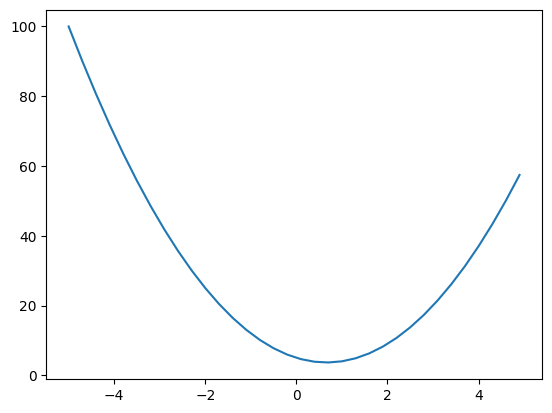

In [209]:
xs = np.arange(-5, 5, 0.3)
ys = f(xs)
plt.plot(xs, ys)

In [210]:
h = 0.0000000001
x = 4.0
(f(x + h) - f(x))/h

20.00000165480742

In [211]:
#the above graph had only one input and one output. but you can have many inputs and one output.
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1 is ', d1)
print('d2 is ', d2)
print('slope is ', (d2 - d1) / h)

d1 is  4.0
d2 is  4.0000000001
slope is  1.000000082740371


In [1]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self.grad = 0.0
        self._op = _op
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if (isinstance(other, Value)) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int or float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data)**(other - 1) * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if (isinstance(other, Value)) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
        
    def __sub__(self, other):
        return self + (-other)

    def __rmul__(self, other): #allows __mul__ to be commutative, ie self * other (now that rmul is defined) equals other * self
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward

        return out
    def __truediv__(self, other): #self / other
        return self * other**(-1)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

#a = Value(2.0, label='a')
#b = Value(-3.0, label='b')
#c = Value(10.0, label='c')
#e = a*b; e.label = 'e'
#d = e + c; d.label = 'd'
#f = Value(-2.0, label='f')
#L = d * f; L.label='L'

In [213]:
a = Value(40.0)
b = a + 4
b

Value(data=44.0)

In [214]:
c = Value(15)
d = c / 30.0
d - c

Value(data=-14.5)

In [7]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR means left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph, create a rectangular (or 'record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            #if this value is the result of some operation, create an op node for it
            dot.node(name =uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

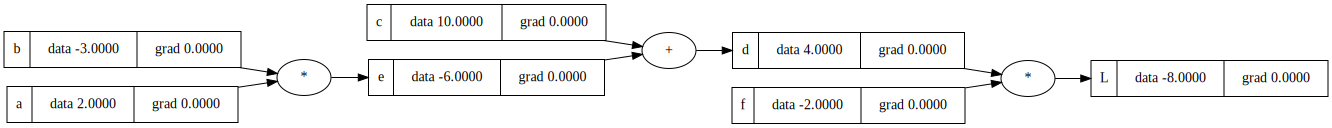

In [216]:
draw_dot(L)

In [217]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-3550.0


In [218]:
#all grad values are with respect to L. how does a nudge in input affect L?
L.grad = 1 #definition)

d.grad = f.data
f.grad = d.data
e.grad = d.grad * 1
c.grad = d.grad * 1
b.grad = d.grad * 1 * a.data
a.grad = d.grad * 1 * b.data


In [219]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

0.0


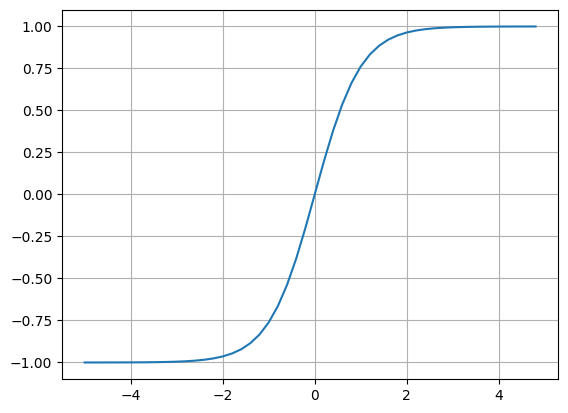

In [220]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [221]:
#xs are inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#w is weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#b is bias of neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

In [223]:
type(n)

__main__.Value

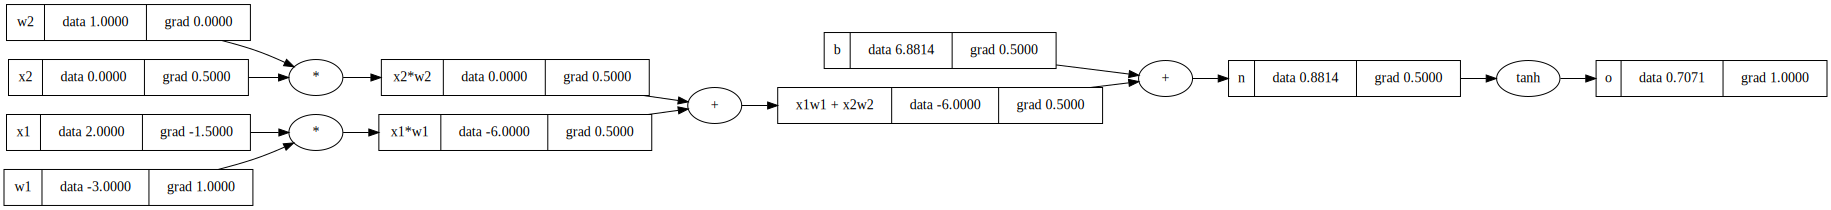

In [224]:
draw_dot(o)

In [225]:
o.backward()

In [6]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=-1),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=2),
 Value(data=1.7627471740390863),
 Value(data=5.828427124746192),
 Value(data=4.828427124746192),
 Value(data=1),
 Value(data=6.828427124746192),
 Value(data=0.1464466094067262),
 Value(data=0.7071067811865477)]

In [227]:
o.grad = 1.0

In [228]:
o._backward()

In [229]:
n._backward()

In [230]:
b._backward()

In [231]:
x1w1x2w2._backward()

In [232]:
x1w1._backward()

In [233]:
x2w2._backward()

In [234]:
o.grad = 1.0
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

In [235]:
1 - o.data**2

0.4999999999999999

In [236]:
#o = tanh(n)
# do/dn = 1 - tanh^2(n) = 1 - o^2

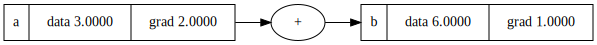

In [237]:
a = Value(3.0, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

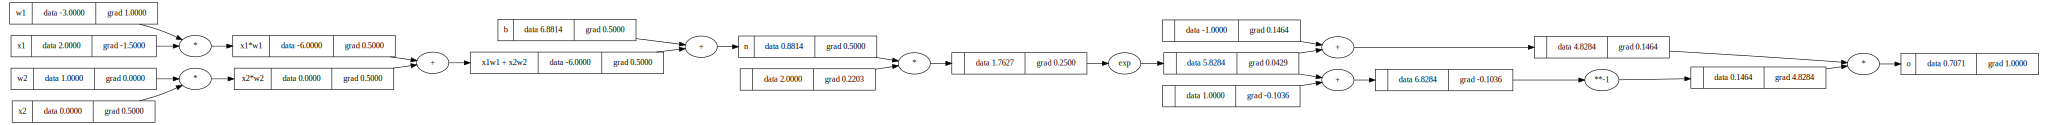

In [8]:
#xs are inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#w is weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#b is bias of neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1); 
o.label = 'o'
o.backward()
draw_dot(o)

In [2]:
type(n)

NameError: name 'n' is not defined

In [2]:
import torch
import random

In [240]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


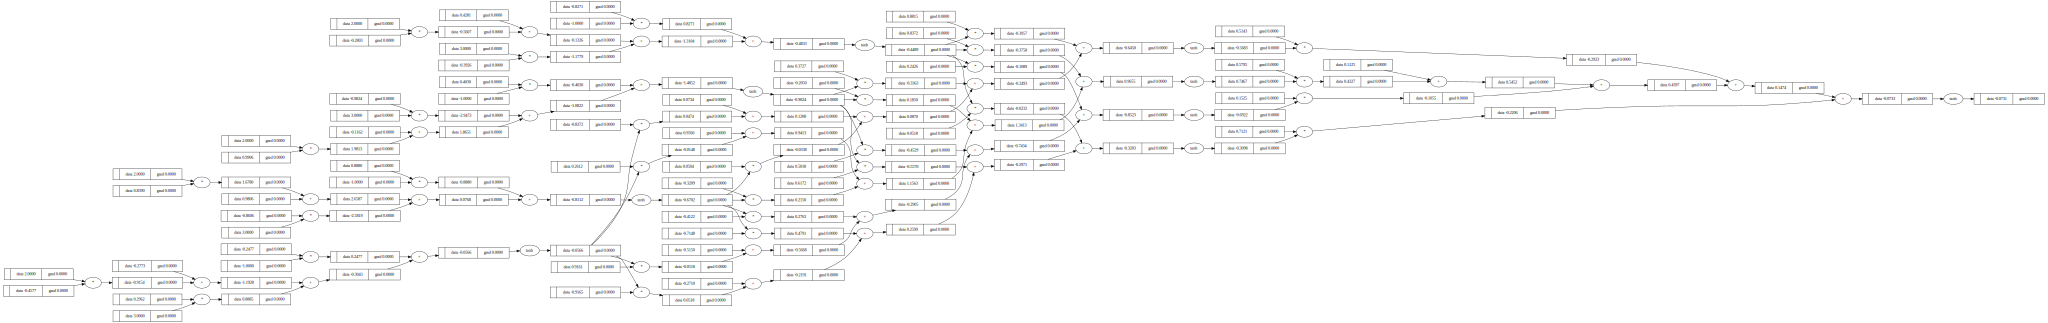

In [9]:
import random
import math
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #w for weight
        self.b = Value(random.uniform(-1,1)) #b for bias

    def __call__(self, x):
    #w dotproduct x plus b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout): #nin is num inputs for each neuron. nout is the number of neurons in the layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
       # return [p for neuron in self.neurons for p in neuron.parameters()]
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
draw_dot(n(x))

In [43]:
fruits = ['apl', 'nna', 'per']
price = [4.0, 1.0, 2.5, 40]
combined = zip(fruits, price)
combinedList = list(combined)
print(combinedList)

[('apl', 4.0), ('nna', 1.0), ('per', 2.5)]


In [6]:
type(n)

__main__.MLP

In [7]:
len(n.parameters())

41

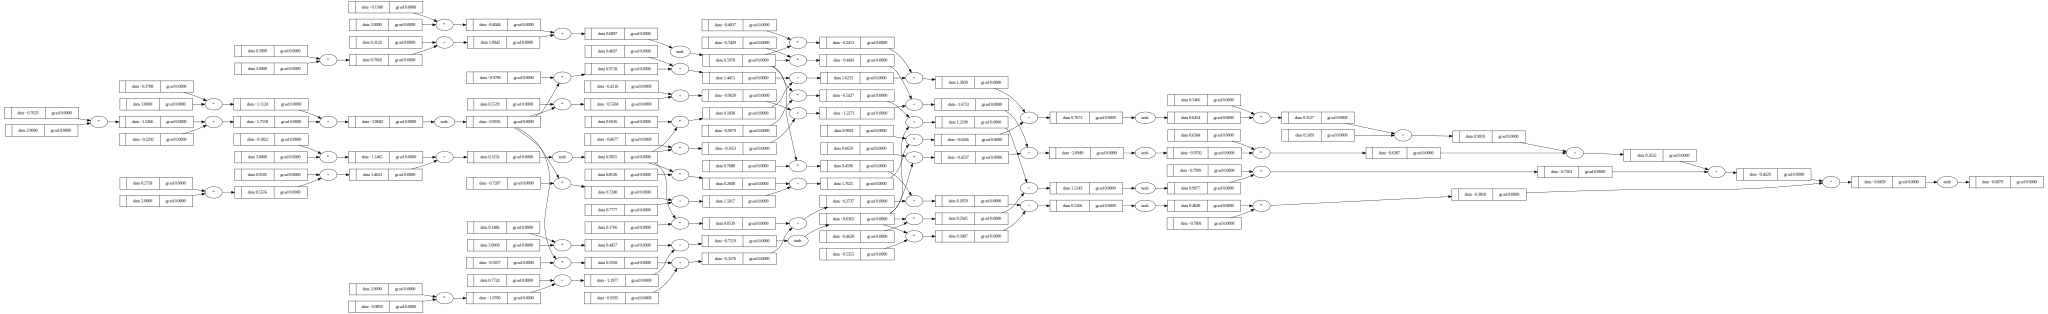

In [247]:
draw_dot(n(x))

In [10]:
#toy example
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.7, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [0.9, -0.69, -0.69, 1.0] ##desirable outputs for each respective input from x
ypred = [n(x) for x in xs]


In [11]:

for j in range(1580):
    #forward pass    
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update (take step / descend)
    for p in n.parameters():
        p.data += -0.01 * p.grad
    if j % 50 == 0:
        print (j, loss.data)

0 2.787293454203269
50 0.0265656205545773
100 0.012837902866975164
150 0.00885814028515982
200 0.007176854570297731
250 0.006322635748820311
300 0.005813366443580382
350 0.005462694551309947
400 0.0051912745365252245
450 0.004962255033759726
500 0.004756959821344889
550 0.004565148739911644
600 0.00438091240622154
650 0.00420085066368386
700 0.004023213656259528
750 0.0038474528202770085
800 0.0036739315103838416
850 0.0035036741542432736
900 0.003338101358697277
950 0.003178747231789575
1000 0.0030269916445637224
1050 0.0028838562933048767
1100 0.0027499023577480667
1150 0.0026252357769424362
1200 0.0025095927728098024
1250 0.0024024613901942136
1300 0.002303199136334381
1350 0.0022111236480573497
1400 0.002125570653656667
1450 0.002045924318628817
1500 0.001971628757170847
1550 0.00190218873233898


In [12]:
ypred

[Value(data=0.9090223037288387),
 Value(data=-0.6884686682700464),
 Value(data=-0.691545157041259),
 Value(data=0.9578356937431748)]

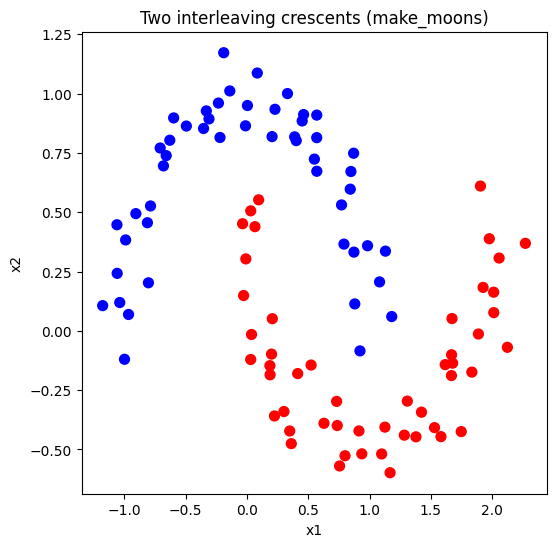

In [14]:
#OUR DATASET WILL BE THESE DOTS! binary classification based on color
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

xs, y = make_moons(n_samples=100, noise=0.1, random_state=42)

plt.figure(figsize=(6,6))
plt.scatter(xs[:,0], xs[:,1], c=y, cmap='bwr', s=50)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Two interleaving crescents (make_moons)')
plt.show()


In [15]:
print(y)

[1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1
 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1]


In [17]:
moonMLP = MLP(2, [10, 10, 1])

#because we are using tanh, whose range is from -1 to 1, change the membership identifiers from 0 and 1 to instead be -1 and 1
ys = [-1 if yi == 0 else 1 for yi in y] #desired targets

for j in range(1500):

    ypred = [moonMLP(x) for x in xs]
    #ypred
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    for p in moonMLP.parameters():
        p.grad = 0
    loss.backward()

#update (take step / descend)
    for p in moonMLP.parameters():
        p.data += -0.01 * p.grad
    if j % 50 == 0:
        print (j, loss.data)

0 84.35599303222644
50 5.340323538451125
100 0.46714283507133814
150 0.2493099882186897
200 0.16370585784286373
250 0.11946948199625276
300 0.09294986590031969
350 0.0754834532143571
400 0.06320628019184536
450 0.054154895240670776
500 0.047233783916467154
550 0.041787001272814456
600 0.03739948048400434
650 0.033796626625977676
700 0.030790001643743282
750 0.028246264534090456
800 0.026068569844544854
850 0.024184983279324043
900 0.022541021446310577
950 0.021094705835741464
1000 0.0198131991608356
1050 0.01867046581863476
1100 0.01764561178843955
1150 0.016721685358173803
1200 0.015884796663753087
1250 0.015123461773418135
1300 0.014428107510627555
1350 0.013790693055195612
1400 0.01320441754164457
1450 0.012663491779914158


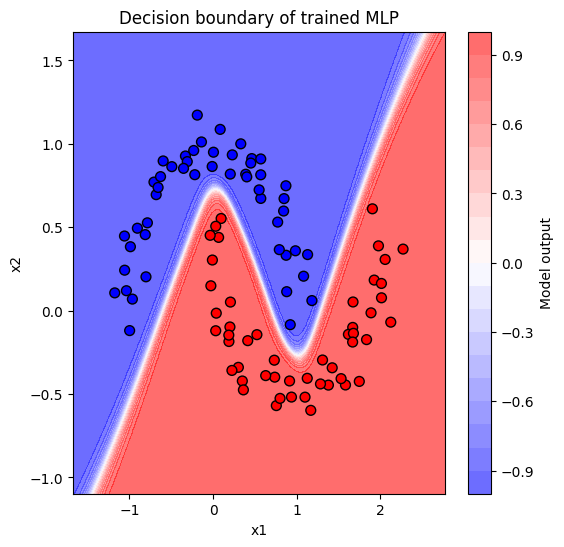

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# define a grid of points covering the data range
x_min, x_max = xs[:,0].min() - 0.5, xs[:,0].max() + 0.5
y_min, y_max = xs[:,1].min() - 0.5, xs[:,1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# flatten the grid so we can feed it through the network
grid_points = np.c_[xx.ravel(), yy.ravel()]

# evaluate the model on each point
zz = [moonMLP(p).data for p in grid_points]   # assuming moonMLP(x) returns a Value
zz = np.array(zz).reshape(xx.shape)

# plot decision boundary and data
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, zz, levels=20, cmap="bwr", alpha=0.6)
plt.colorbar(label='Model output')

# original points
plt.scatter(xs[:,0], xs[:,1], c=y, cmap='bwr', edgecolor='k', s=50)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Decision boundary of trained MLP")
plt.show()
